In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

# Training data preparation 

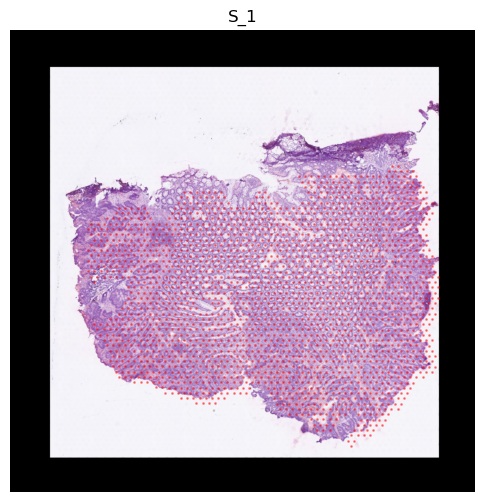

In [2]:
with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [3]:

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("./dataset/version-7/no_gu_clip4_processed_train_spots.h5", "r") as f:
    train_spots = f["spots/log2_Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
        print(slide_name)

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './dataset/version-7/no_gu_clip4_processed_train_spots.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## log 2

In [17]:
import h5py
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# -----------------------------------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，並以 slide 名稱建立 DataFrame 字典
# -----------------------------------------------------
#with h5py.File("dataset/filtered&masked_dataset.h5", "r") as f:

with h5py.File("dataset/filtered&masked_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"✅ 已讀取 slide: {slide_name}")

# -----------------------------------------------------
# Step 2: 合併所有 slide 的資料
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

if "slide_name" not in all_train_spots_df.columns:
    all_train_spots_df["slide_name"] = all_train_spots_df.index.map(lambda i: "unknown")

# -----------------------------------------------------
# Step 3: 對每一個 spot 的 cell abundances 進行排名
# -----------------------------------------------------
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("C")]

# 建立一個新的 DataFrame 儲存排名資訊
ranked_df = all_train_spots_df.copy()

# 對每一行做排名（axis=1）
ranked_values = all_train_spots_df[cell_type_cols].apply(
    lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
)
# 原始 abundance | 排名 (ordinal)
# 最大值 | 最大 rank（數字 最大）
# 最小值 | 1

# 用 "rank_" + 原本欄位名稱
ranked_values.columns = [f"rank_{col}" for col in cell_type_cols]

# 再和原資料合併
ranked_df = pd.concat([ranked_df.drop(columns=cell_type_cols), ranked_values], axis=1)
# -----------------------------------------------------
# Step 4: 顯示排名後的統計描述
# -----------------------------------------------------
print("\n🏁 Ranking done! 每個 cell type 的排名描述:")
print(ranked_df[[col for col in ranked_df.columns if col.startswith("rank_C")]].describe())

# ranked_df 現在就可以用來做 Spearman-based 模型訓練 🎯


✅ 已讀取 slide: S_1
✅ 已讀取 slide: S_2
✅ 已讀取 slide: S_3
✅ 已讀取 slide: S_4
✅ 已讀取 slide: S_5
✅ 已讀取 slide: S_6

🏁 Ranking done! 每個 cell type 的排名描述:
           rank_C1      rank_C2      rank_C3      rank_C4      rank_C5  \
count  8069.000000  8069.000000  8069.000000  8069.000000  8069.000000   
mean     25.992068    27.383443    26.392366    17.233858    25.659313   
std       7.821885     3.593941     5.962511    12.172144    11.122902   
min       7.000000    15.000000    10.000000     1.000000     1.000000   
25%      19.000000    24.000000    21.000000     6.000000    17.000000   
50%      27.000000    28.000000    26.000000    14.000000    31.000000   
75%      34.000000    31.000000    33.000000    32.000000    34.000000   
max      35.000000    35.000000    35.000000    35.000000    35.000000   

           rank_C6      rank_C7      rank_C8      rank_C9     rank_C10  ...  \
count  8069.000000  8069.000000  8069.000000  8069.000000  8069.000000  ...   
mean     15.417772    20.118230    1

In [18]:
import numpy as np
import pandas as pd

# 假设 all_train_spots_df, ranked_df 已经存在

cell_cols = [f"C{i}" for i in range(1,36)]
rank_cols = [f"rank_C{i}" for i in range(1,36)]

expr  = all_train_spots_df[cell_cols].values    # (N,35)
ranks = ranked_df[rank_cols].values             # (N,35)

# 计算加权系数
min_expr   = expr.min(axis=1, keepdims=True)
scaled     = expr / min_expr * 2
log2_coeff = np.log2(scaled)                    # (N,35)

# 乘上原始 rank 得到 wranks
wranks = log2_coeff                     # (N,35)

# 直接替换 ranked_df 中的 rank 列
for i, col in enumerate(rank_cols):
    ranked_df[col] = wranks[:, i]

# 这样，ranked_df 里原先的 rank_* 就被新的 wrank_* 覆盖了
print(ranked_df[rank_cols].head())


     rank_C1    rank_C2    rank_C3    rank_C4    rank_C5    rank_C6  \
0  10.705398  12.702791  11.318897   7.625883  15.917996  17.419285   
1  13.307512  14.070438  13.236315  11.860359  18.895135   9.230524   
2  14.858261  12.964997  13.738951   9.419677  17.909055  10.997495   
3  12.975031  14.398167  13.018248  10.317543  19.617078  13.658933   
4  12.386135  11.433950  12.009961  10.936140  17.123081   5.393708   

     rank_C7    rank_C8    rank_C9   rank_C10  ...  rank_C26   rank_C27  \
0  10.794000  11.181376  16.996032  17.537501  ...  6.871065  17.871508   
1  13.037257   7.222302  11.016971  15.584535  ...  5.915564  10.299275   
2  10.997596   4.667938  15.201920  13.834495  ...  4.415690  15.026726   
3  14.081453   9.864314  14.864968  12.490619  ...  7.494189  13.675598   
4  10.129398   4.284452  10.738018   5.726693  ...  1.582818   7.946503   

    rank_C28   rank_C29  rank_C30   rank_C31   rank_C32   rank_C33  rank_C34  \
0  13.780485   9.733983  1.000000  12.0625

In [19]:
ranked_df

x     y slide_name    rank_C1    rank_C2    rank_C3    rank_C4  \
0     1554  1297        S_1  10.705398  12.702791  11.318897   7.625883   
1      462  1502        S_1  13.307512  14.070438  13.236315  11.860359   
2     1488  1548        S_1  14.858261  12.964997  13.738951   9.419677   
3     1725  1182        S_1  12.975031  14.398167  13.018248  10.317543   
4      581  1113        S_1  12.386135  11.433950  12.009961  10.936140   
...    ...   ...        ...        ...        ...        ...        ...   
8064  1173   842        S_6  12.316015  14.919392  12.517419  10.822903   
8065  1237   775        S_6  15.700636  15.413834  15.556551  11.437665   
8066   903   953        S_6  12.849424  17.373674  14.519968   9.141792   
8067   954  1310        S_6  11.382078  14.348739  11.886208   8.274593   
8068  1186   864        S_6  17.522387  15.228299  14.994886  10.253957   

        rank_C5    rank_C6    rank_C7  ...   rank_C26   rank_C27   rank_C28  \
0     15.917996  17.419285  10.794000  ...   6.871065  17.871508  13.780485   
1     18.895135   9.230524  13.037257  ...   5.915564  10.299275   4.373842   
2     17.909055  10.997495  10.997596  ...   4.415690  15.026726   8.286475   
3     19.617078  13.658933  14.081453  ...   7.494189  13.675598   7.545891   
4     17.123081   5.393708  10.129398  ...   1.582818   7.946503   1.000000   
...         ...        ...        ...  ...        ...        ...        ...   
8064  21.561843   6.703750  14.554518  ...   8.680270  11.916293   4.789263   
8065  20.712189   6.302491  13.679951  ...   9.579387   6.513024  10.261372   
8066  20.514836   8.398584  14.215625  ...  11.020318   9.198125   7.096189   
8067  20.589266   7.340700  14.278697  ...   3.692366  13.089186   6.652231   
8068  21.349961   7.229598  14.813384  ...   6.615927  11.423538   5.934488   

       rank_C29  rank_C30   rank_C31   rank_C32   rank_C33  rank_C34  \
0      9.733983  1.000000  12.062503  12.024591  13.751379  7.414866   
1     11.036301  1.000000  14.212565  13.100470   8.456942  8.490562   
2      7.282567  1.000000  12.414079  12.033351   9.860208  6.564170   
3     12.079928  1.000000  14.015112  14.185486   8.411159  7.403653   
4      8.049660  4.608536  11.099534  10.388435   2.162186  2.150680   
...         ...       ...        ...        ...        ...       ...   
8064  12.714849  2.070102  14.420891  13.418111   7.422235  7.451402   
8065  14.970648  7.263934  14.925887  14.086072   8.364306  7.439534   
8066   9.459247  8.077182  16.614686  15.116452  19.173290  7.971306   
8067  12.343271  5.047195  14.178094  13.059233   7.172107  6.887956   
8068  13.273844  3.413873  14.761832  13.706183  14.641053  7.807977   

       rank_C35  
0     12.502811  
1     12.076207  
2     11.739860  
3     13.378544  
4      9.092672  
...         ...  
8064  12.643824  
8065  12.621380  
8066  13.119823  
8067  12.307296  
8068  13.074018  

[8069 rows x 38 columns]

In [9]:
import pandas as pd

# 假设你的 DataFrame 叫 ranked_df
rank_cols = [f"rank_C{i}" for i in range(1, 36)]

# 1) 生成 group_id（对每一组相同的 rank 向量）：
ranked_df["group_id"] = ranked_df.groupby(rank_cols, sort=True).ngroup()

# 2) 查看每个 group 有多少行：
group_sizes = ranked_df.groupby("group_id").size().rename("count")
print(group_sizes.sort_values(ascending=False).head(10))

# 3) 如果你想把所有在同一 group 里的行拿出来，比如查看 group 0：
group0 = ranked_df[ranked_df["group_id"] == 0]
print(group0)

# ——完整例子——
print("总共有", ranked_df["group_id"].nunique(), "个不同的 rank 组合。")


group_id
0       1
5574    1
5572    1
5571    1
5570    1
5569    1
5568    1
5567    1
5566    1
5565    1
Name: count, dtype: int64
       x     y slide_name   rank_C1   rank_C2   rank_C3   rank_C4    rank_C5  \
655  710  1327        S_1  4.290092  7.235815  4.874193  1.337461  10.194517   

      rank_C6   rank_C7  ...  rank_C27  rank_C28  rank_C29  rank_C30  \
655  6.726414  4.974459  ...  7.528444  7.273392  2.168478  1.549564   

     rank_C31  rank_C32  rank_C33  rank_C34  rank_C35  group_id  
655  6.009272   5.95395   9.96133  1.382984  4.693564         0  

[1 rows x 39 columns]
总共有 8345 个不同的 rank 组合。


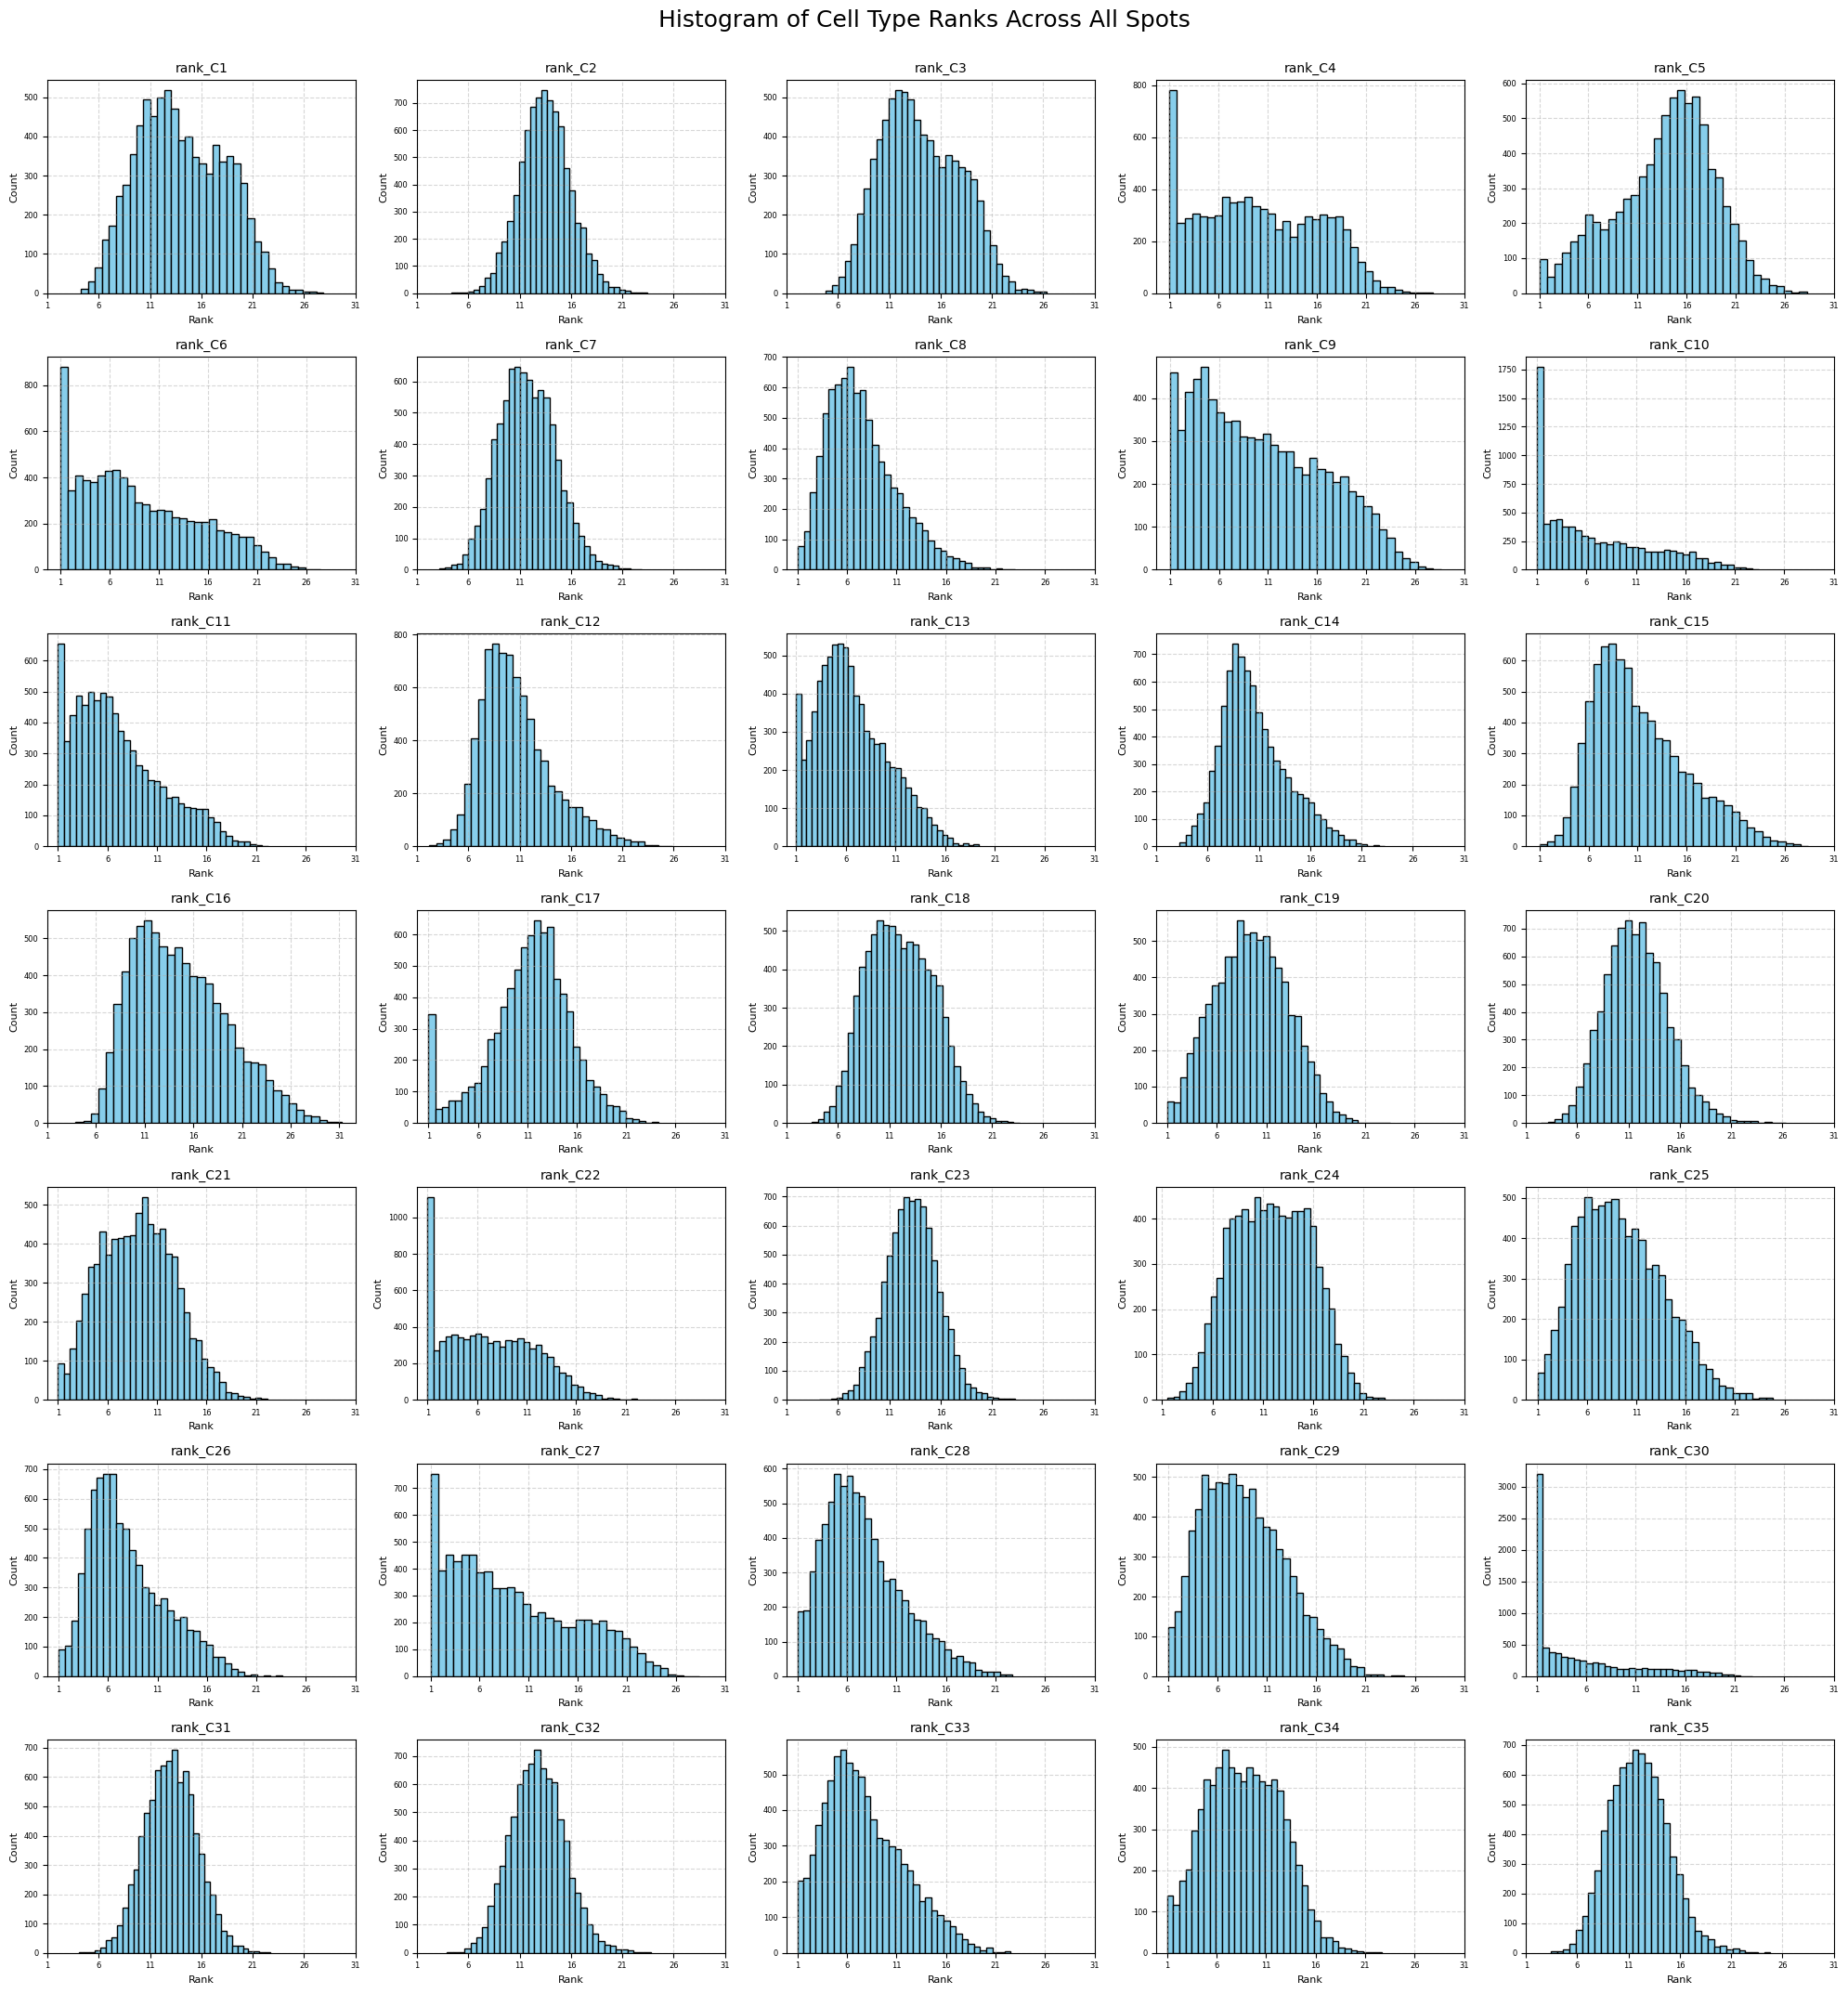

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 原始資料：filtered_df[zscore_cols] 是 samples × cell types，我們要做 corr → cell × cell
zscore_cols = ["rank_" + col for col in cell_type_cols]
zscore_data = ranked_df[zscore_cols]

# 把欄位名稱簡化（optional，讓圖比較乾淨）
zscore_data.columns = cell_type_cols

# 計算相關矩陣（cell types × cell types）
corr_matrix = zscore_data.corr(method='pearson')  # or 'spearman' if non-normal

# 畫出 correlation heatmap + clustering
sns.clustermap(
    corr_matrix,
    method='ward',      # clustering 方法：ward / average / complete / single
    metric='euclidean', # 或用 'correlation' 做距離
    cmap='vlag',        # 紅藍色調
    figsize=(10, 10),
    annot=False         # 要不要在格子裡寫數字
)
plt.title("Cell Type × Cell Type Correlation Clustermap")
plt.show()


In [4]:
import h5py
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree
from scipy.stats import rankdata, spearmanr, pearsonr
import matplotlib.pyplot as plt

def gaussian_spatial_smoothing(df, cell_type_cols, radius=80, sigma=None):
    coords = df[["x", "y"]].values
    tree = KDTree(coords)
    sigma = sigma or (radius / 2)
    smoothed = []
    for i in range(len(df)):
        idxs, dists = tree.query_radius([coords[i]], r=radius, return_distance=True)
        idxs = idxs[0]
        dists = dists[0]
        if len(idxs) == 0:
            smoothed.append(df.iloc[i][cell_type_cols].values)
            continue
        weights = np.exp(- (dists ** 2) / (2 * sigma ** 2))
        weights = weights / (weights.sum() + 1e-8)
        neighbor_vals = df.iloc[idxs][cell_type_cols].values
        weighted_vals = np.average(neighbor_vals, axis=0, weights=weights)
        smoothed.append(weighted_vals)
    smoothed_array = np.vstack(smoothed)
    smoothed_df = df.copy()
    smoothed_df[cell_type_cols] = smoothed_array
    return smoothed_df

def plot_cell_expression_comparison_with_round(
    slide_id,
    cell_type,
    original_df,
    radius,
    smoothed_df,
    image_array,
    round_num,
    cmap="plasma"
):
    x = original_df["x"].values
    y = original_df["y"].values
    z_orig = original_df[cell_type].values
    z_smooth = smoothed_df[cell_type].values
    vmin = min(z_orig.min(), z_smooth.min())
    vmax = max(z_orig.max(), z_smooth.max())
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    spearman_corr = spearmanr(z_orig, z_smooth)
    pearson_corr = pearsonr(z_orig, z_smooth)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(image_array)
    sc1 = axes[0].scatter(x, y, c=z_orig, cmap=cmap, s=15, norm=norm)
    axes[0].set_title(f"{slide_id} - Original")
    axes[0].axis("off")
    plt.colorbar(sc1, ax=axes[0])

    axes[1].imshow(image_array)
    sc2 = axes[1].scatter(x, y, c=z_smooth, cmap=cmap, s=15, norm=norm)
    axes[1].set_title(
        f"{slide_id} - Round {round_num} Smoothed\n"
        f"r={pearson_corr.statistic:.2f}, ρ={spearman_corr.statistic:.2f}"
    )
    axes[1].axis("off")
    plt.colorbar(sc2, ax=axes[1])

    plt.suptitle(f"{cell_type} - Expression Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"▶️ Round {round_num} Pearson r = {pearson_corr.statistic:.4f}, p = {pearson_corr.pvalue:.4g}")
    print(f"▶️ Round {round_num} Spearman ρ = {spearman_corr.statistic:.4f}, p = {spearman_corr.pvalue:.4g}")

def process_slide_smoothing_and_ranking(
    spot_h5_path,
    image_h5_path,
    slide_id,
    cell_prefix="C",
    cell_type_to_plot="C1",
    radius=80,
    rounds=1
):
    if isinstance(slide_id, str):
        slide_ids = [slide_id]
    else:
        slide_ids = slide_id

    # 用來收集每個 slide、每一輪的 correlation 結果
    log = []

    for sid in slide_ids:
        print(f"\n====================== 📌 Slide {sid} ======================\n")

        with h5py.File(spot_h5_path, "r") as f:
            spot_array = np.array(f[f"spots/Train/{sid}"])

        with h5py.File(image_h5_path, "r") as f:
            image_array = np.array(f[f"images/Train/{sid}"])

        df = pd.DataFrame(spot_array)
        df["slide_name"] = sid
        cell_type_cols = [col for col in df.columns if col.startswith(cell_prefix)]

        if cell_type_to_plot not in cell_type_cols:
            raise ValueError(f"❌ '{cell_type_to_plot}' 不在欄位中，請確認 cell_prefix 與 cell_type 名稱！")

        baseline_df = df.copy()
        current_df = df.copy()

        for r in range(rounds):
            print(f"\n🔁 Round {r+1} smoothing with radius = {radius}")
            smoothed_df = gaussian_spatial_smoothing(current_df, cell_type_cols, radius=radius)

            # 排名
            ranked_values = smoothed_df[cell_type_cols].apply(
                lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
            )
            ranked_values.columns = cell_type_cols
            ranked_df = pd.concat([smoothed_df.drop(columns=cell_type_cols), ranked_values], axis=1)

            # 所有 cell type correlation 平均
            pearsons = []
            spearmans = []
            for col in cell_type_cols:
                r_pear = pearsonr(baseline_df[col], smoothed_df[col]).statistic
                r_spear = spearmanr(baseline_df[col], smoothed_df[col]).statistic
                pearsons.append(r_pear)
                spearmans.append(r_spear)

            avg_p = np.mean(pearsons)
            avg_s = np.mean(spearmans)
            print(f"📊 Slide {sid} - Round {r+1} - Avg Pearson r = {avg_p:.4f}, Avg Spearman ρ = {avg_s:.4f}")

            # 指定 cell type correlation
            cell_p = pearsonr(baseline_df[cell_type_to_plot], smoothed_df[cell_type_to_plot])
            cell_s = spearmanr(baseline_df[cell_type_to_plot], smoothed_df[cell_type_to_plot])
            print(f"🔍 {sid} - {cell_type_to_plot} - Pearson: {cell_p.statistic:.4f}, Spearman: {cell_s.statistic:.4f}")

            # 畫圖
            plot_cell_expression_comparison_with_round(
                slide_id=sid,
                cell_type=cell_type_to_plot,
                original_df=baseline_df,
                radius=radius,
                smoothed_df=smoothed_df,
                image_array=image_array,
                round_num=r+1
            )

            # 記錄這一輪結果
            log.append({
                "slide": sid,
                "round": r+1,
                "cell_type": cell_type_to_plot,
                "cell_type_pearson": cell_p.statistic,
                "cell_type_spearman": cell_s.statistic,
                "avg_pearson": avg_p,
                "avg_spearman": avg_s
            })

            current_df = smoothed_df.copy()

        print(f"\n✅ Slide {sid} 完成 {rounds} 輪 smoothing + 排名 + correlation 分析")

    # 建成 dataframe 並顯示每個 slide 的平均 correlation
    log_df = pd.DataFrame(log)
    print("\n================== 📈 Overall Slide-level Average Correlation ==================\n")
    summary = log_df.groupby("slide")[["cell_type_pearson", "cell_type_spearman", "avg_pearson", "avg_spearman"]].mean()
    print(summary.round(4))

    return log_df



====================== 📌 Slide S_1 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_1 - Round 1 - Avg Pearson r = 0.8478, Avg Spearman ρ = 0.8341
🔍 S_1 - rank_C8 - Pearson: 0.7409, Spearman: 0.7247


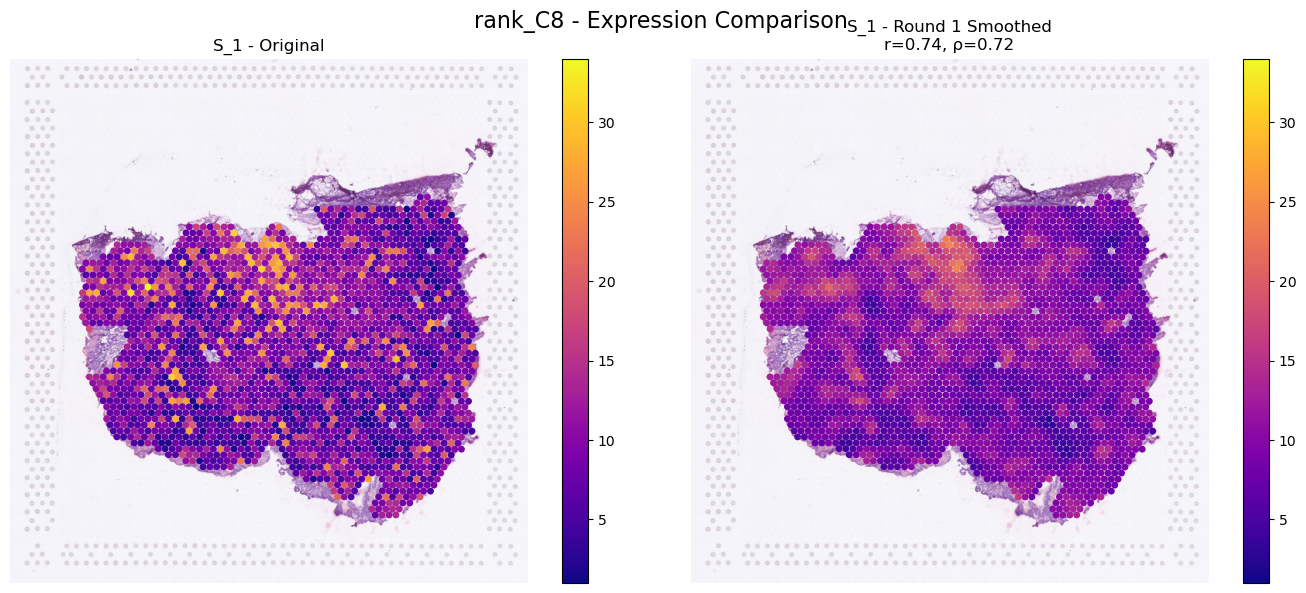

▶️ Round 1 Pearson r = 0.7409, p = 0
▶️ Round 1 Spearman ρ = 0.7247, p = 0

✅ Slide S_1 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_2 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_2 - Round 1 - Avg Pearson r = 0.8391, Avg Spearman ρ = 0.7974
🔍 S_2 - rank_C8 - Pearson: 0.7467, Spearman: 0.6506


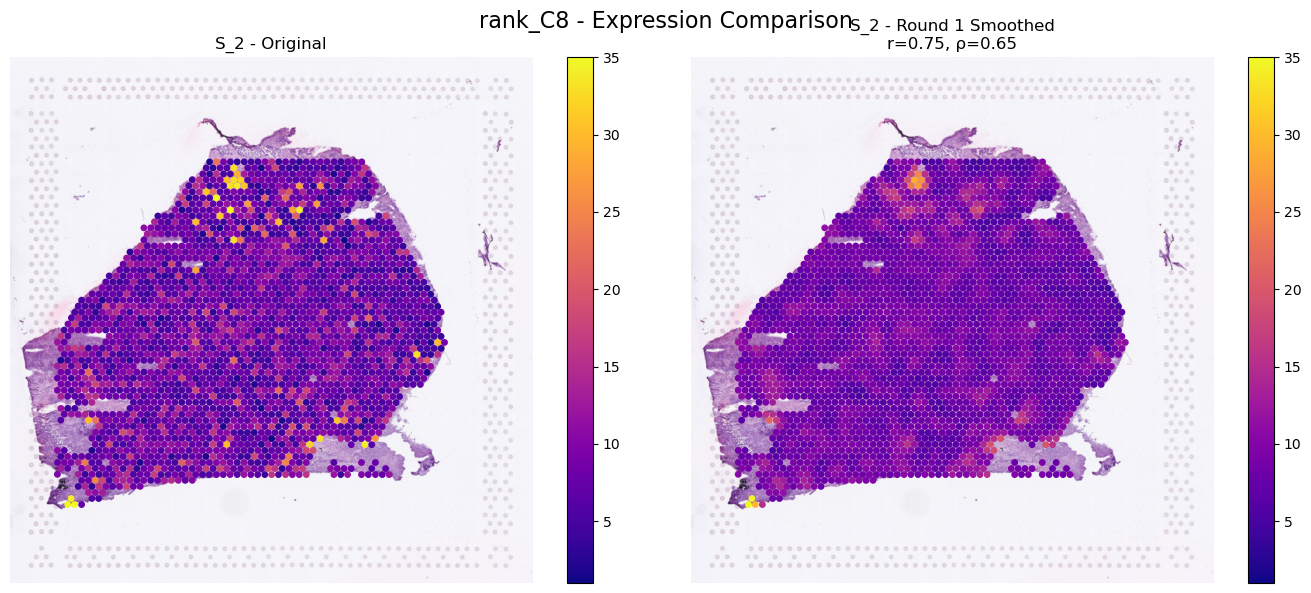

▶️ Round 1 Pearson r = 0.7467, p = 0
▶️ Round 1 Spearman ρ = 0.6506, p = 2.853e-273

✅ Slide S_2 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_3 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_3 - Round 1 - Avg Pearson r = 0.7926, Avg Spearman ρ = 0.7650
🔍 S_3 - rank_C8 - Pearson: 0.7032, Spearman: 0.6694


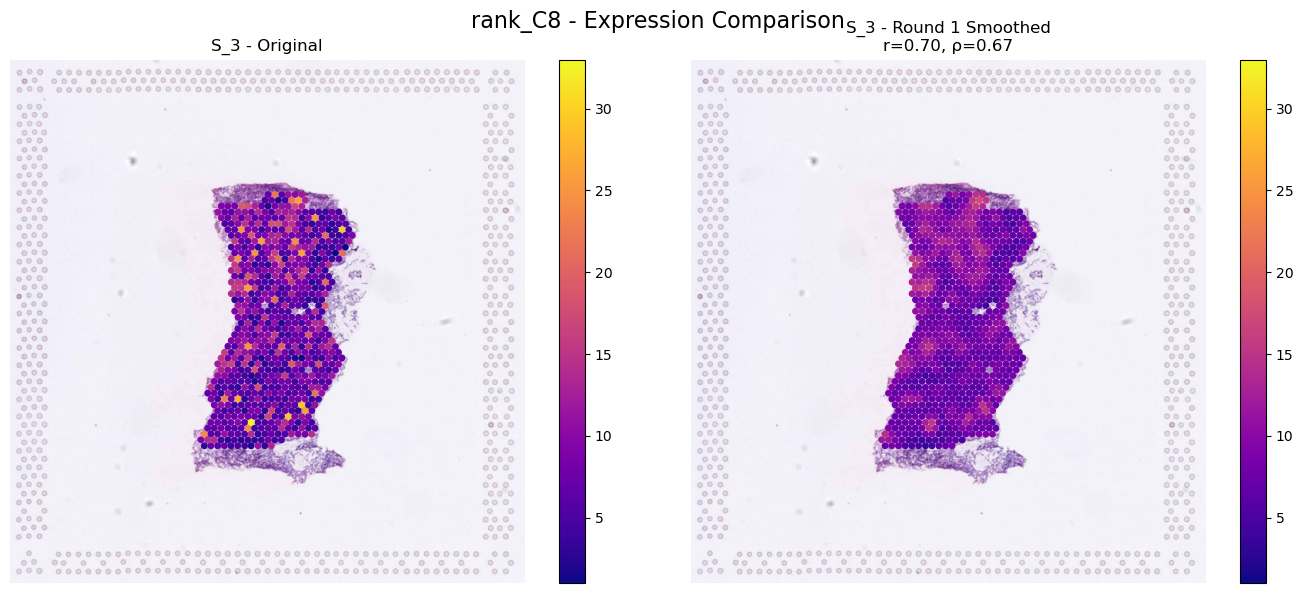

▶️ Round 1 Pearson r = 0.7032, p = 5.229e-104
▶️ Round 1 Spearman ρ = 0.6694, p = 7.038e-91

✅ Slide S_3 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_4 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_4 - Round 1 - Avg Pearson r = 0.8724, Avg Spearman ρ = 0.8595
🔍 S_4 - rank_C8 - Pearson: 0.7027, Spearman: 0.6795


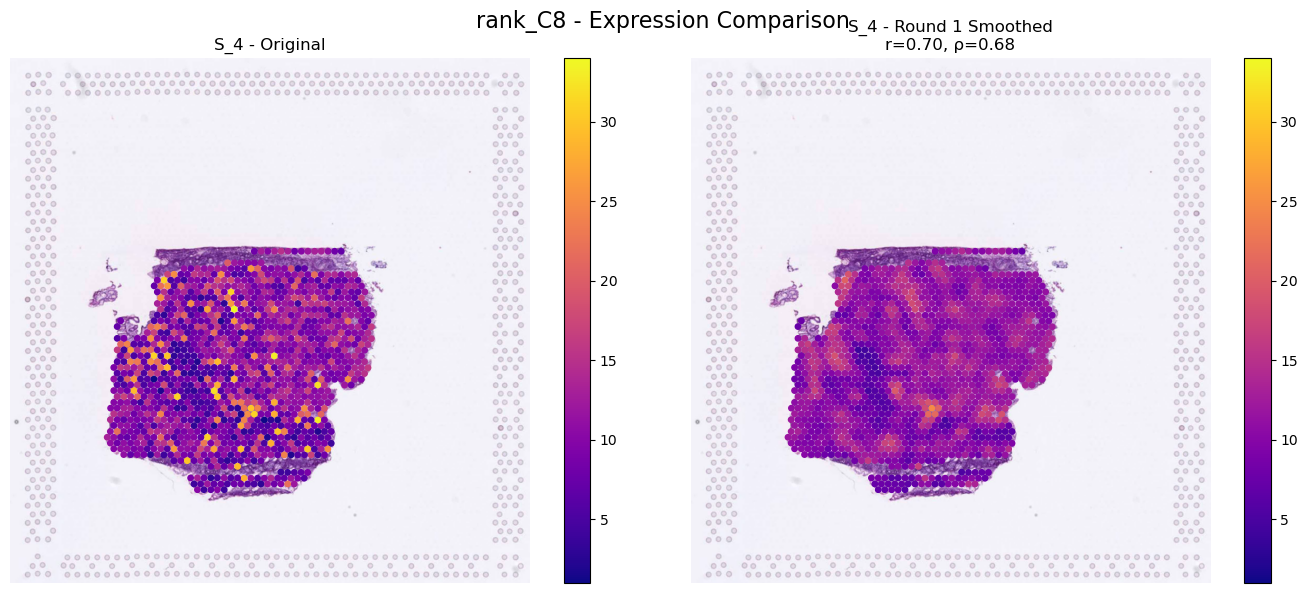

▶️ Round 1 Pearson r = 0.7027, p = 2.01e-177
▶️ Round 1 Spearman ρ = 0.6795, p = 1.494e-161

✅ Slide S_4 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_5 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_5 - Round 1 - Avg Pearson r = 0.8547, Avg Spearman ρ = 0.8371
🔍 S_5 - rank_C8 - Pearson: 0.7896, Spearman: 0.8002


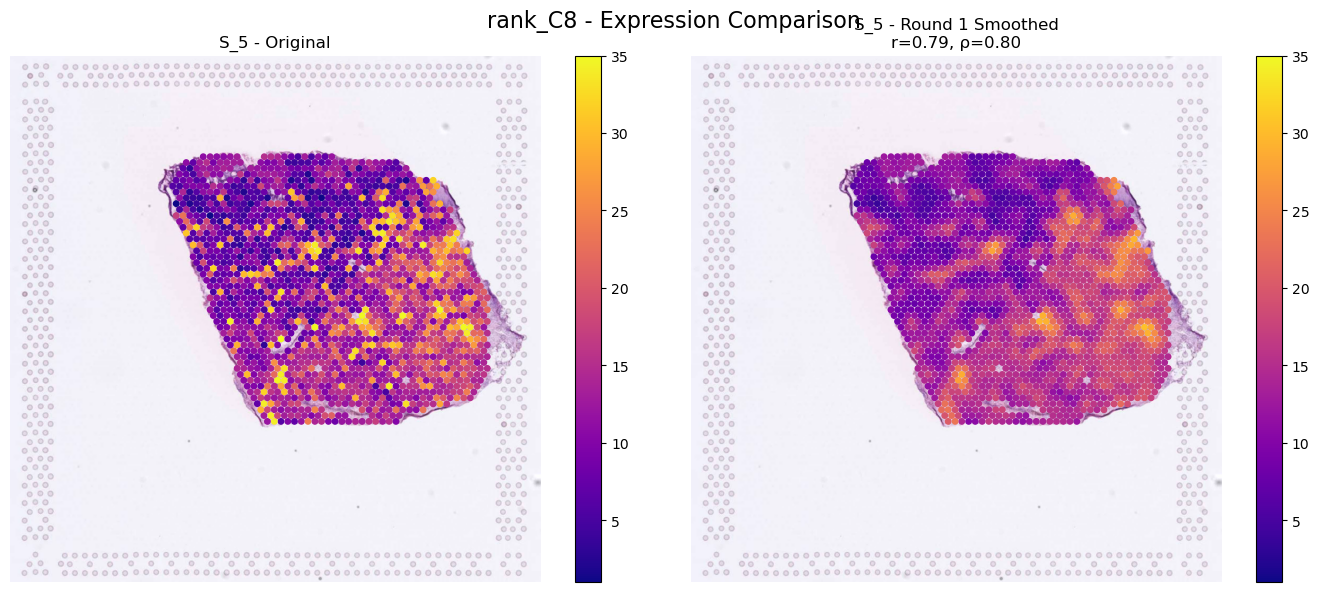

▶️ Round 1 Pearson r = 0.7896, p = 0
▶️ Round 1 Spearman ρ = 0.8002, p = 0

✅ Slide S_5 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_6 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_6 - Round 1 - Avg Pearson r = 0.8291, Avg Spearman ρ = 0.8197
🔍 S_6 - rank_C8 - Pearson: 0.7094, Spearman: 0.7001


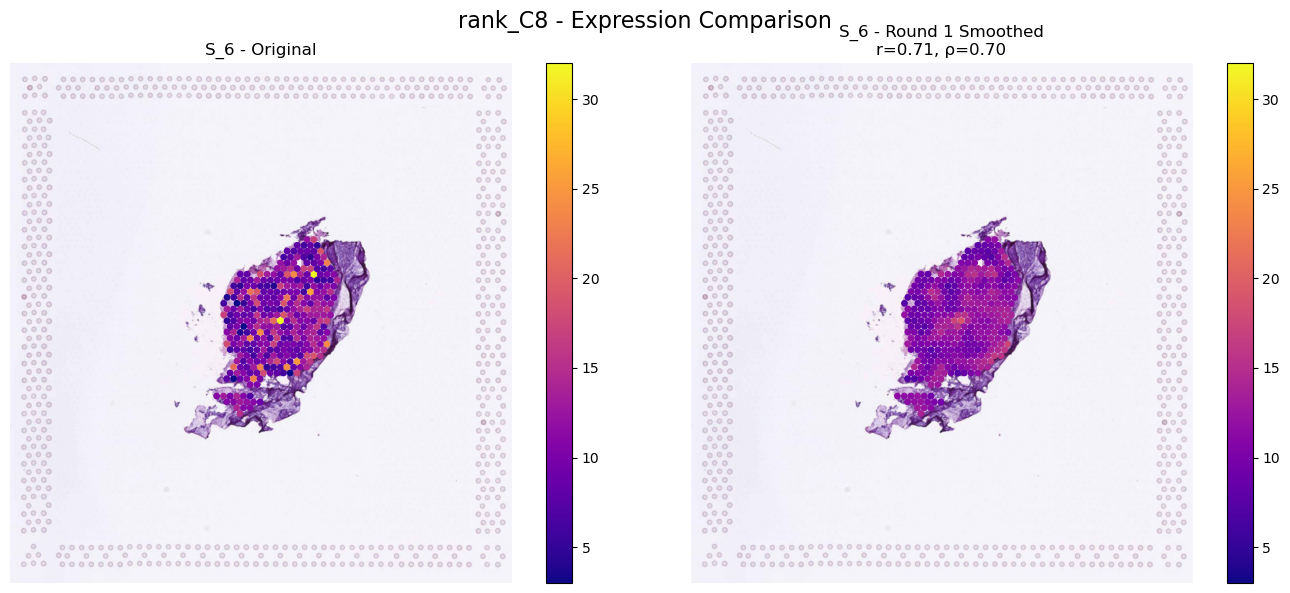

▶️ Round 1 Pearson r = 0.7094, p = 1.827e-51
▶️ Round 1 Spearman ρ = 0.7001, p = 1.322e-49

✅ Slide S_6 完成 1 輪 smoothing + 排名 + correlation 分析

================== 📈 Overall Slide-level Average Correlation ==================

       cell_type_pearson  cell_type_spearman  avg_pearson  avg_spearman
slide                                                                  
S_1               0.7409              0.7247       0.8478        0.8341
S_2               0.7467              0.6506       0.8391        0.7974
S_3               0.7032              0.6694       0.7926        0.7650
S_4               0.7027              0.6795       0.8724        0.8595
S_5               0.7896              0.8002       0.8547        0.8371
S_6               0.7094              0.7001       0.8291        0.8197


slide  round cell_type  cell_type_pearson  cell_type_spearman  avg_pearson  \
0   S_1      1   rank_C8           0.740869            0.724671     0.847814   
1   S_2      1   rank_C8           0.746693            0.650608     0.839111   
2   S_3      1   rank_C8           0.703200            0.669428     0.792586   
3   S_4      1   rank_C8           0.702745            0.679470     0.872394   
4   S_5      1   rank_C8           0.789634            0.800210     0.854674   
5   S_6      1   rank_C8           0.709408            0.700058     0.829127   

   avg_spearman  
0      0.834139  
1      0.797436  
2      0.764980  
3      0.859478  
4      0.837107  
5      0.819723

In [13]:

process_slide_smoothing_and_ranking(
    spot_h5_path="dataset/realign/spot-rank/version-1/directly_rank_train_spots.h5",
    image_h5_path="./dataset/elucidata_ai_challenge_data.h5",
    slide_id=["S_1", "S_2", "S_3","S_4", "S_5", "S_6"],  # ✅ 傳 list 會依序處理每個 slide
    cell_prefix="rank_C",             # 例如處理 C1~C35
    cell_type_to_plot="rank_C8",     # 但只畫出 C14
    radius=40,
    rounds=1
)


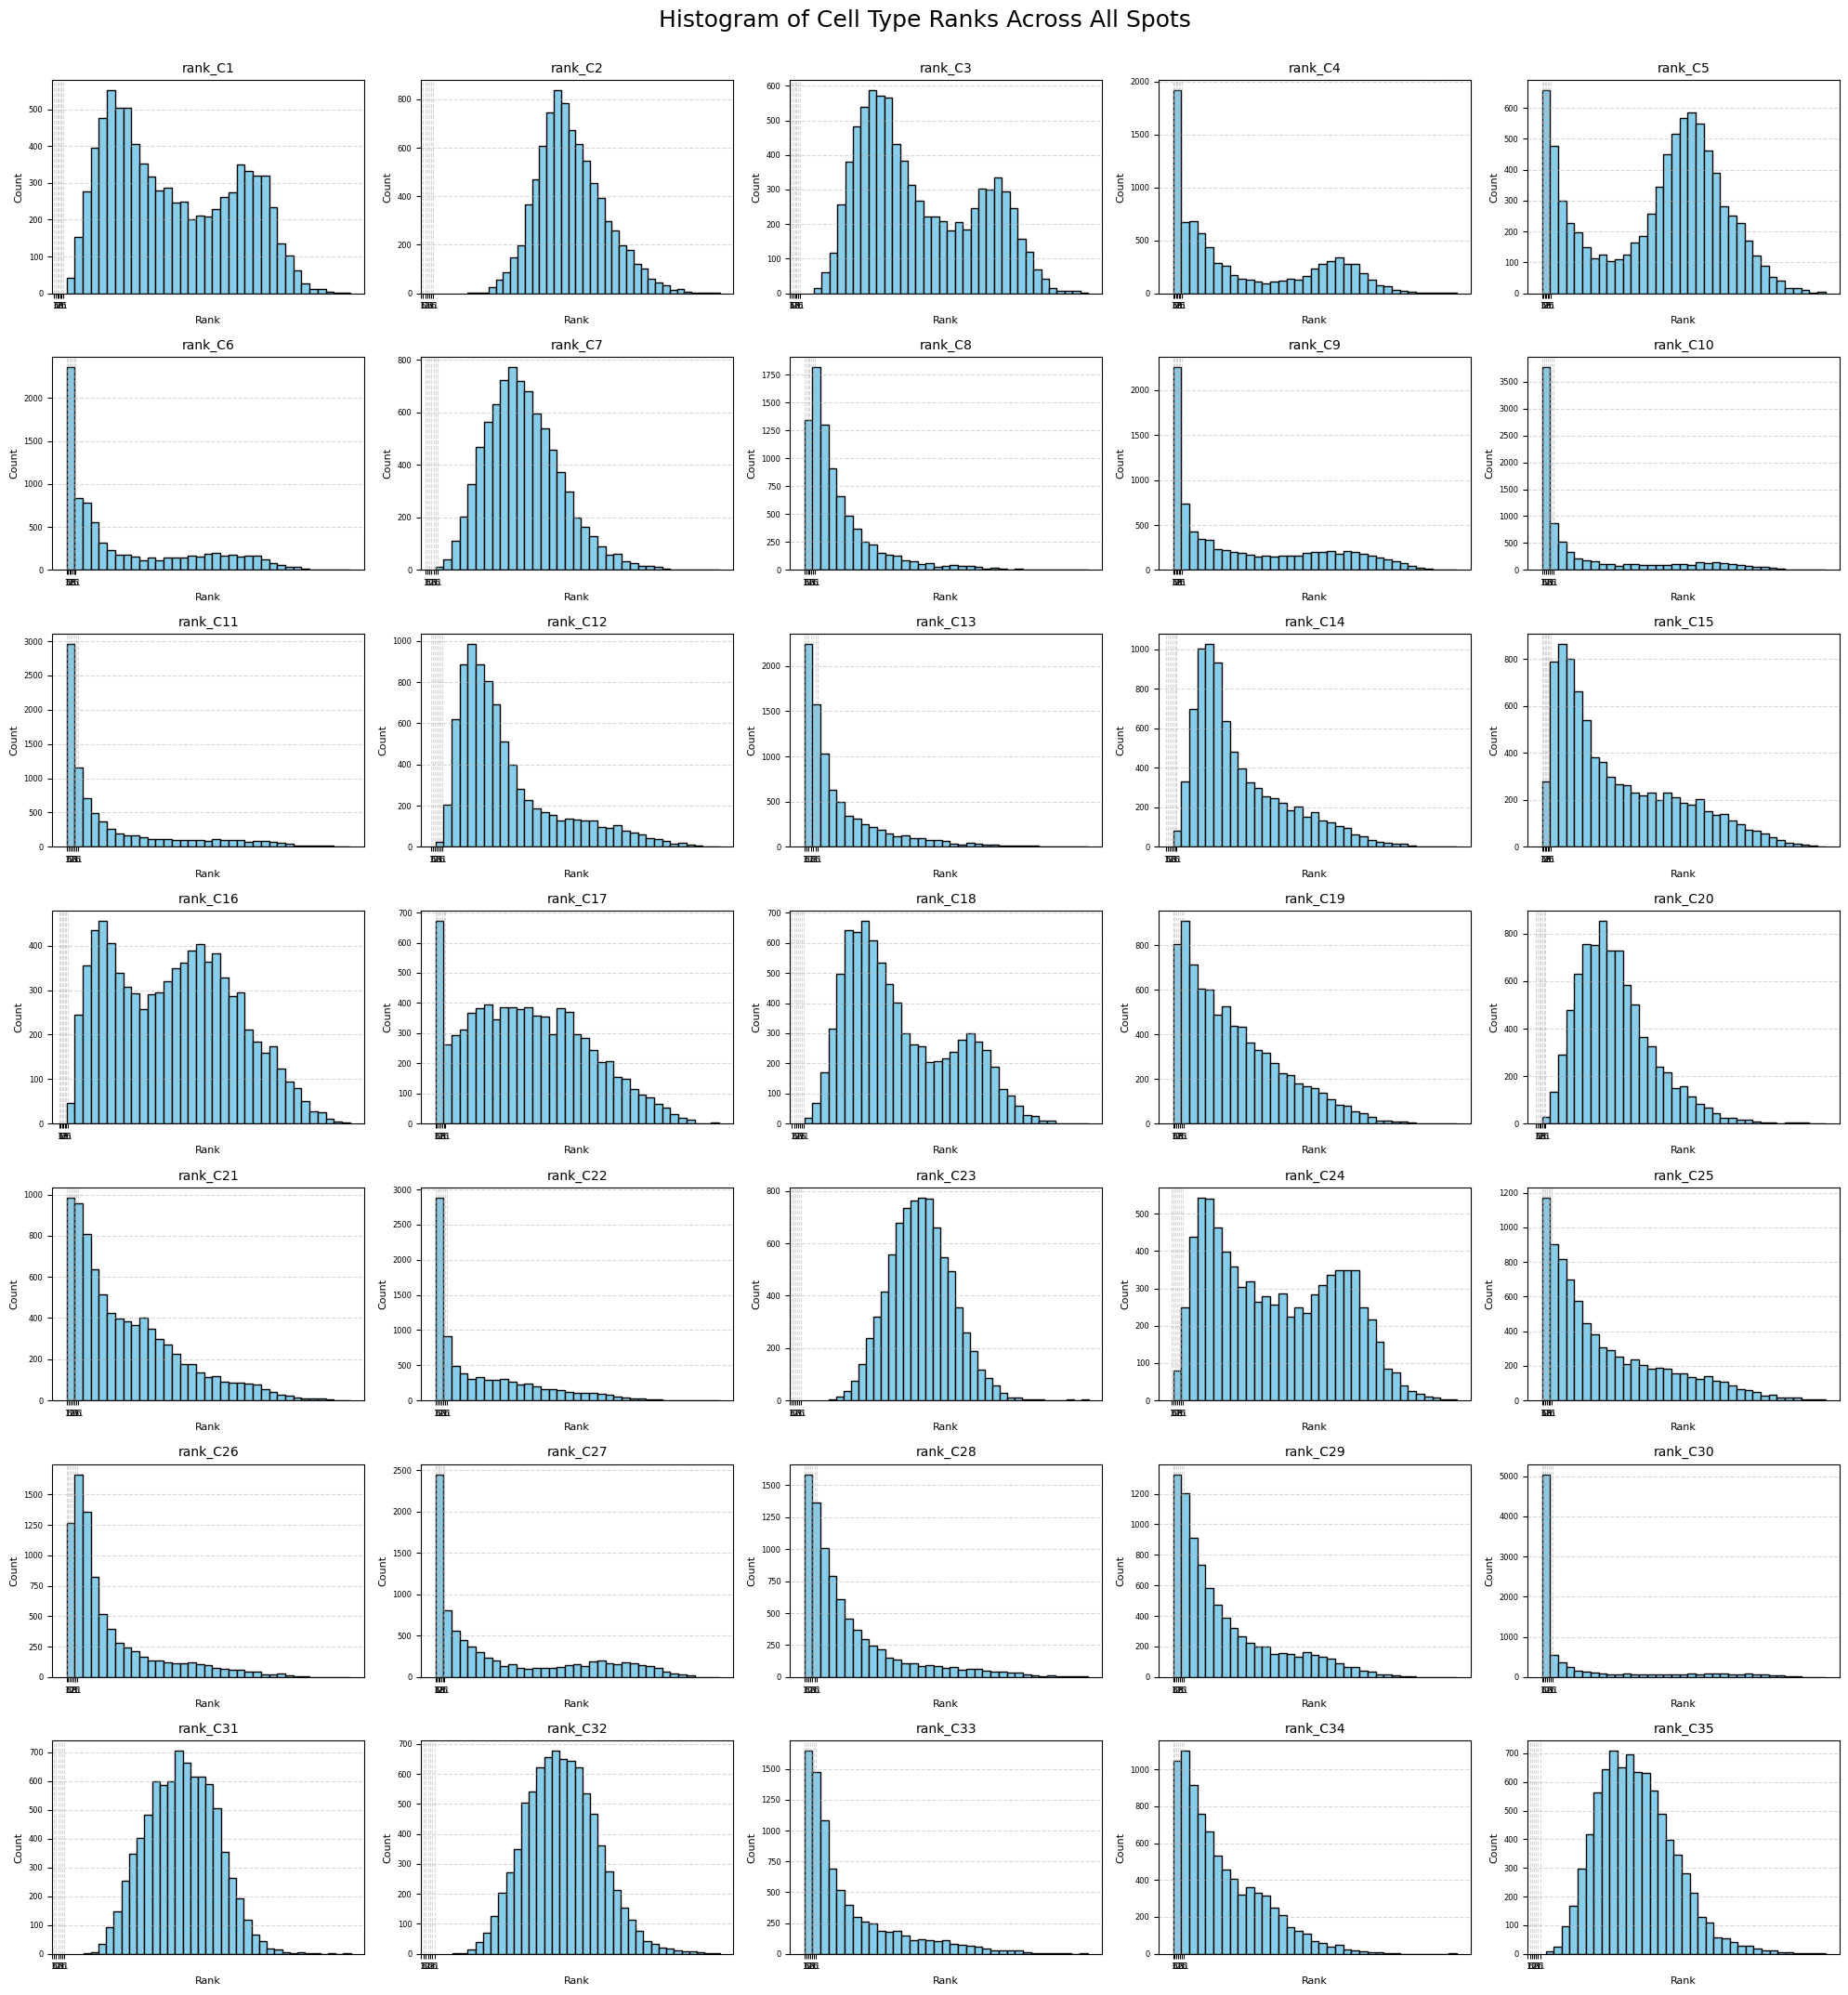

In [42]:
import matplotlib.pyplot as plt
import math

# 所有排名欄位
rank_cols = [col for col in ranked_df.columns if col.startswith("rank_")]
n_plots = len(rank_cols)

# 設定 subplot 的行與列數（例如每列 5 張圖）
n_cols = 5
n_rows = math.ceil(n_plots / n_cols)

# 建立畫布
plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, col in enumerate(rank_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(ranked_df[col], bins=35, color='skyblue', edgecolor='black')
    plt.title(col, fontsize=10)
    plt.xlabel("Rank", fontsize=8)
    plt.ylabel("Count", fontsize=8)
    plt.xticks(range(1, 36, 5), fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Histogram of Cell Type Ranks Across All Spots", fontsize=18, y=1.02)
plt.show()


## Save data

In [20]:
import h5py
import numpy as np
import pandas as pd

# 假設 filtered_df (包含 slide_name, x, y 與所有 zscore_log2_filtered_{cell} 欄位) 
# 與 cell_type_cols 以及 zscore_params 已經存在

# 例如：
# cell_type_cols = ['C1', 'C2', ..., 'C35']
# zscore_params = {"C1": {"mean": ..., "std": ...}, "C2": {"mean": ..., "std": ...}, ...}
# filtered_df 為預處理後的 DataFrame

# 設定輸出 HDF5 檔案路徑
save_folder = "./dataset/spot-rank/version-v/no_realgin/filtered&masked/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
output_file = os.path.join(save_folder, "log2_nor_rank_spots.h5")

with h5py.File(output_file, "w") as f_out:
    # 建立 group "spots/Train"
    slides_group = f_out.create_group("spots/Train")
    
    # 根據 slide_name 分組，並將每個 slide 的資料存入 dataset
    for slide_name, group_df in ranked_df.groupby("slide_name"):
        # 選擇需要儲存的欄位：x, y 以及所有 zscore_log2_filtered_{cell} 欄位

        cols_to_save = ["x", "y"] + [f"rank_{col}" for col in cell_type_cols]
        # 取出對應的資料
        df_to_save = group_df[cols_to_save].copy()
        
        # 將 DataFrame 轉成 numpy 結構化陣列（不保存 index）
        rec_array = df_to_save.to_records(index=False)
        
        # 存入 group，鍵為 slide_name
        slides_group.create_dataset(slide_name, data=rec_array)
        print(f"Slide {slide_name} 資料已存入 HDF5。")
    print(f"Saved{cols_to_save}")

        
print(f"所有資料與參數已存入 HDF5 檔案：{output_file}")


Slide S_1 資料已存入 HDF5。
Slide S_2 資料已存入 HDF5。
Slide S_3 資料已存入 HDF5。
Slide S_4 資料已存入 HDF5。
Slide S_5 資料已存入 HDF5。
Slide S_6 資料已存入 HDF5。
Saved['x', 'y', 'rank_C1', 'rank_C2', 'rank_C3', 'rank_C4', 'rank_C5', 'rank_C6', 'rank_C7', 'rank_C8', 'rank_C9', 'rank_C10', 'rank_C11', 'rank_C12', 'rank_C13', 'rank_C14', 'rank_C15', 'rank_C16', 'rank_C17', 'rank_C18', 'rank_C19', 'rank_C20', 'rank_C21', 'rank_C22', 'rank_C23', 'rank_C24', 'rank_C25', 'rank_C26', 'rank_C27', 'rank_C28', 'rank_C29', 'rank_C30', 'rank_C31', 'rank_C32', 'rank_C33', 'rank_C34', 'rank_C35']
所有資料與參數已存入 HDF5 檔案：./dataset/spot-rank/version-v/no_realgin/filtered&masked/log2_nor_rank_spots.h5


In [47]:
import h5py
import numpy as np
import pandas as pd

# 假設 filtered_df (包含 slide_name, x, y 與所有 zscore_log2_filtered_{cell} 欄位) 
# 與 cell_type_cols 以及 zscore_params 已經存在

# 例如：
# cell_type_cols = ['C1', 'C2', ..., 'C35']
# zscore_params = {"C1": {"mean": ..., "std": ...}, "C2": {"mean": ..., "std": ...}, ...}
# filtered_df 為預處理後的 DataFrame

# 設定輸出 HDF5 檔案路徑
save_folder = "./dataset/spot-rank/version-3/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
output_file = os.path.join(save_folder, "rank_times_expr_train_spots.h5")

with h5py.File(output_file, "w") as f_out:
    # 建立 group "spots/Train"
    slides_group = f_out.create_group("spots/Train")
    
    # 根據 slide_name 分組，並將每個 slide 的資料存入 dataset
    for slide_name, group_df in ranked_df.groupby("slide_name"):
        # 選擇需要儲存的欄位：x, y 以及所有 zscore_log2_filtered_{cell} 欄位

        cols_to_save = ["x", "y"] + [f"rank_{col}" for col in cell_type_cols]
        # 取出對應的資料
        df_to_save = group_df[cols_to_save].copy()
        
        # 將 DataFrame 轉成 numpy 結構化陣列（不保存 index）
        rec_array = df_to_save.to_records(index=False)
        
        # 存入 group，鍵為 slide_name
        slides_group.create_dataset(slide_name, data=rec_array)
        print(f"Slide {slide_name} 資料已存入 HDF5。")
    print(f"Saved{cols_to_save}")

        
print(f"所有資料與參數已存入 HDF5 檔案：{output_file}")


Slide S_1 資料已存入 HDF5。
Slide S_2 資料已存入 HDF5。
Slide S_3 資料已存入 HDF5。
Slide S_4 資料已存入 HDF5。
Slide S_5 資料已存入 HDF5。
Slide S_6 資料已存入 HDF5。
Saved['x', 'y', 'rank_C1', 'rank_C2', 'rank_C3', 'rank_C4', 'rank_C5', 'rank_C6', 'rank_C7', 'rank_C8', 'rank_C9', 'rank_C10', 'rank_C11', 'rank_C12', 'rank_C13', 'rank_C14', 'rank_C15', 'rank_C16', 'rank_C17', 'rank_C18', 'rank_C19', 'rank_C20', 'rank_C21', 'rank_C22', 'rank_C23', 'rank_C24', 'rank_C25', 'rank_C26', 'rank_C27', 'rank_C28', 'rank_C29', 'rank_C30', 'rank_C31', 'rank_C32', 'rank_C33', 'rank_C34', 'rank_C35']
所有資料與參數已存入 HDF5 檔案：./dataset/spot-rank/version-3/rank_times_expr_train_spots.h5


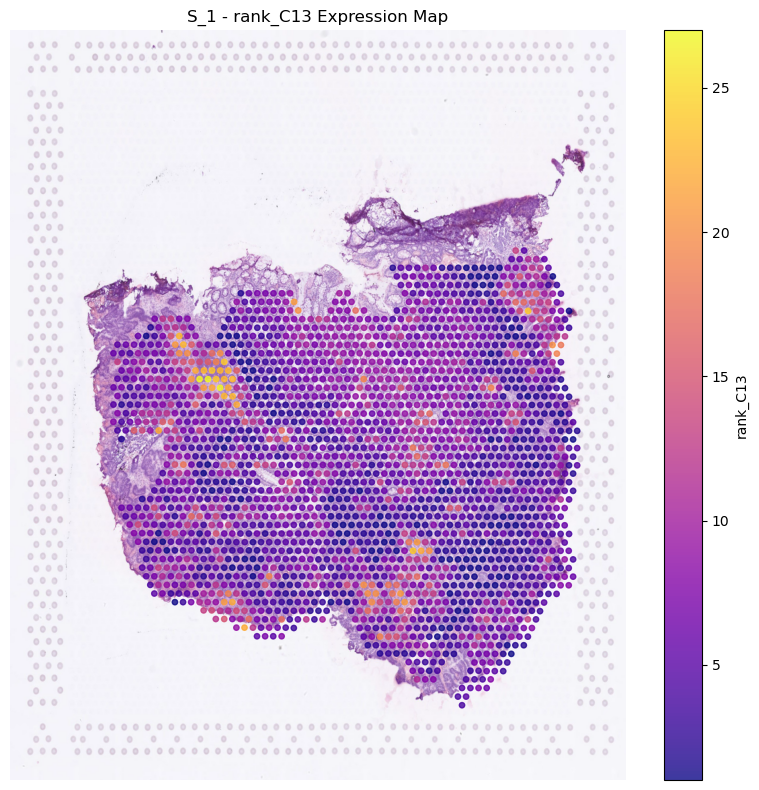

In [84]:
from python_scripts.expression_plot_utils import plot_cell_expression_on_slide
plot_cell_expression_on_slide(
    slide_id = "S_1",
    cell_type = "C13",
    cell_prefix="rank_",  # or zscore_boxcox_filtered_
    image_path="./dataset/elucidata_ai_challenge_data.h5",
    spot_path="dataset/spot-rank/version-2/gu_rank_radius_30.h5",
    group_name="Train"
)